<a href="https://colab.research.google.com/github/manisha-1112/Speech-Separation-Recognition/blob/main/MVDR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

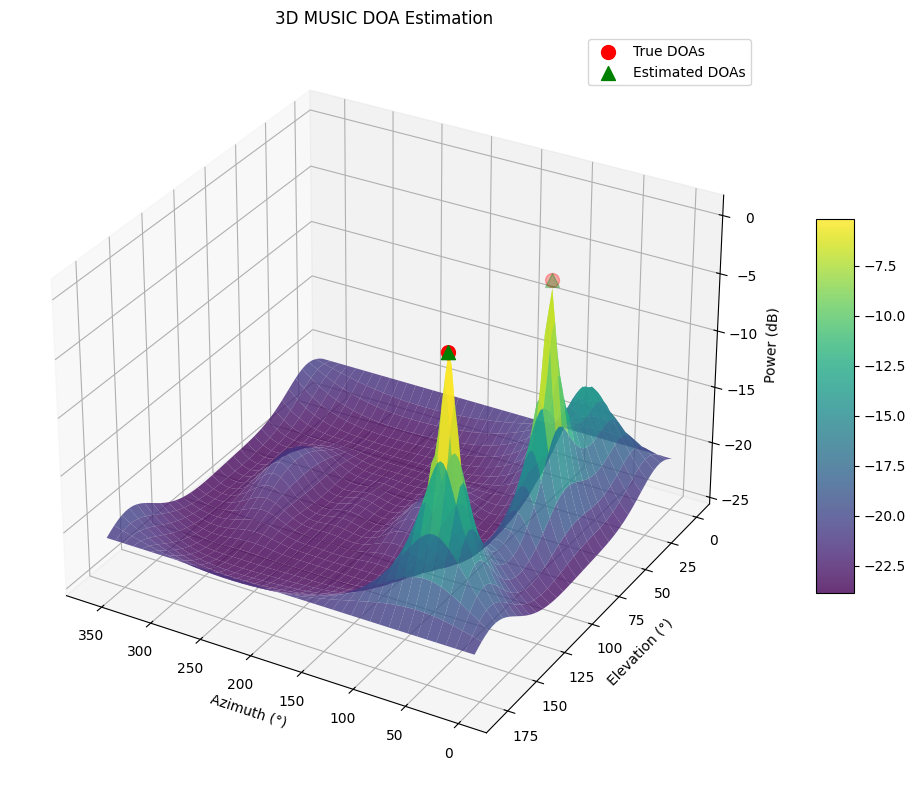

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh, pinv
from scipy.signal import stft, istft
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
import soundfile as sf
from mpl_toolkits.mplot3d import Axes3D

# PARAMETERS
n_sensors = 8
spacing = 0.5
n_sources = 2
fs= 2000 #fs = 16000
snr_db = 20
n_samples = 256 #n_samples = 2048
duration_samples = int(fs * 0.12)
source_angles = np.array([[45, 75], [60, 150]])
azimuth_grid = np.linspace(0, 360, 121)
elevation_grid = np.linspace(0, 180, 61)

# STEERING VECTOR
def steering_vector_3d(azimuth, elevation):
    az = np.radians(azimuth)
    el = np.radians(elevation)
    positions = np.array([
        [0, 0, 0], [spacing, 0, 0], [0, spacing, 0], [0, 0, spacing],
        [spacing, spacing, 0], [spacing, 0, spacing], [0, spacing, spacing],
        [spacing, spacing, spacing]
    ])
    k = np.array([
        np.sin(el) * np.cos(az),
        np.sin(el) * np.sin(az),
        np.cos(el)
    ])
    return np.exp(-1j * 2 * np.pi * positions @ k)

# SIGNAL GENERATION
def generate_received_signal_3d(source_angles, n_samples):
    s = (np.random.randn(n_sources, n_samples) + 1j * np.random.randn(n_sources, n_samples)) / np.sqrt(2)
    A = np.column_stack([steering_vector_3d(az, el) for az, el in source_angles])
    noise_power = 10**(-snr_db / 10)
    noise = np.sqrt(noise_power / 2) * (np.random.randn(n_sensors, n_samples) + 1j * np.random.randn(n_sensors, n_samples))
    return A @ s + noise, s

X, true_sources = generate_received_signal_3d(source_angles, n_samples)

# STFT
n_fft = 256
hop = 128
f, t, Zxx = stft(X, fs=fs, nperseg=n_fft, noverlap=n_fft - hop, return_onesided=False)

# MUSIC SPECTRUM
az_mesh, el_mesh = np.meshgrid(azimuth_grid, elevation_grid)
spectrum_3d = np.zeros_like(az_mesh, dtype=float)

for k in range(10, 30):
    Rxx = Zxx[:, k, :] @ Zxx[:, k, :].conj().T / Zxx.shape[2]
    eigvals, eigvecs = eigh(Rxx)
    noise_space = eigvecs[:, :-n_sources]
    for i in range(az_mesh.shape[0]):
        for j in range(az_mesh.shape[1]):
            a = steering_vector_3d(az_mesh[i, j], el_mesh[i, j])
            denom = np.real(a.conj().T @ noise_space @ noise_space.conj().T @ a)
            spectrum_3d[i, j] += 1 / (denom + 1e-10)

spectrum_3d = 10 * np.log10(spectrum_3d / np.max(spectrum_3d))
spectrum_3d = np.clip(spectrum_3d, -30, None)

# PEAK DETECTION
def find_peaks_3d(spectrum, n_peaks=2):
    flat = spectrum.ravel()
    top_indices = np.argsort(flat)[-n_peaks:]
    return np.unravel_index(top_indices, spectrum.shape)

peak_indices = find_peaks_3d(spectrum_3d, n_sources)
estimated_az = az_mesh[peak_indices]
estimated_el = el_mesh[peak_indices]
estimated_angles = np.column_stack((estimated_az, estimated_el))

# ANGULAR RMSE
def angular_rmse(true_angles, est_angles):
    diff = np.abs(true_angles - est_angles)
    diff[:, 0] = np.minimum(diff[:, 0], 360 - diff[:, 0])
    diff[:, 1] = np.minimum(diff[:, 1], 180 - np.abs(180 - diff[:, 1]))
    return np.sqrt(np.mean(np.sum(diff**2, axis=1)))

distances = cdist(source_angles, estimated_angles, metric='cityblock')
row_ind, col_ind = linear_sum_assignment(distances)
matched_estimates = estimated_angles[col_ind]
rmse = angular_rmse(source_angles, matched_estimates)

# MVDR BEAMFORMING
def mvdr_beamform(Zxx, doa):
    n_sensors, n_freqs, n_frames = Zxx.shape
    Y = np.zeros((n_freqs, n_frames), dtype=complex)
    for k in range(n_freqs):
        R = Zxx[:, k, :] @ Zxx[:, k, :].conj().T / n_frames
        a = steering_vector_3d(*doa)
        R_inv = pinv(R)
        w = R_inv @ a / (a.conj().T @ R_inv @ a + 1e-10)
        for t_idx in range(n_frames):
            Y[k, t_idx] = w.conj().T @ Zxx[:, k, t_idx]
    return Y

# Apply MVDR beamformer to each estimated DOA
Zxx_mvdr = [mvdr_beamform(Zxx, doa) for doa in matched_estimates]

# ISTFT to Time Domain
_, mixed_time = istft(np.mean(Zxx, axis=0), fs=fs, nperseg=n_fft, noverlap=n_fft - hop)
separated_time = [istft(Y, fs=fs, nperseg=n_fft, noverlap=n_fft - hop)[1] for Y in Zxx_mvdr]

# Normalize
def normalize(x):
    x = np.real(x)
    x = x / (np.max(np.abs(x)) + 1e-10)
    return x.astype(np.float32)

# MUSIC Spectrum Plotting
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(az_mesh, el_mesh, spectrum_3d, cmap='viridis', alpha=0.8)
ax.scatter(source_angles[:, 0], source_angles[:, 1], [0]*n_sources, c='r', s=100, marker='o', label='True DOAs')
ax.scatter(estimated_az, estimated_el, [0]*n_sources, c='g', s=100, marker='^', label='Estimated DOAs')
ax.set_xlabel('Azimuth (°)')
ax.set_ylabel('Elevation (°)')
ax.set_zlabel('Power (dB)')
ax.set_title('3D MUSIC DOA Estimation')
ax.view_init(elev=30, azim=120)
plt.colorbar(surf, shrink=0.5, aspect=10)
plt.legend()
plt.tight_layout()
plt.show()
